# Graph Clustering

This notebook performs **graph-based clustering analysis** on COVID-19 confirmed case time series data across countries. The goal is to identify groups of countries that exhibited similar pandemic progression patterns.

### Methodology

1. **Data Preparation**: Load and aggregate COVID-19 data by country and date
2. **Similarity Computation**: Calculate pairwise Pearson correlation between countries' time series
3. **Graph Construction**: Build a k-nearest neighbor (k-NN) similarity graph
4. **Community Detection**: Apply two clustering algorithms:
   - **Louvain Algorithm**: Modularity-based community detection
   - **Spectral Clustering**: Eigendecomposition-based partitioning

In [1]:
import pandas as pd                              
import numpy as np                               

import matplotlib.pyplot as plt                
import seaborn as sns                           

import networkx as nx                    

from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import SpectralClustering   

from community import community_louvain        

plt.style.use('seaborn-v0_8-darkgrid')  # Modern seaborn style with grid
sns.set_palette('husl')                  # Perceptually uniform color palette

In [3]:

df = pd.read_csv('covid_19_data.csv')

# basic dataset information
print(f"Dataset shape: {df.shape}")           
print(f"Column names: {df.columns.tolist()}") 
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: (306429, 8)
Column names: ['SNo', 'ObservationDate', 'Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered']

First 5 rows:


,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [5]:

df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])


ts_data = df.groupby(['Country/Region', 'ObservationDate'])['Confirmed'].sum().reset_index()

# Reshape: rows = countries, columns = dates, values = confirmed cases
ts_pivot = ts_data.pivot(index='Country/Region', columns='ObservationDate', values='Confirmed')
ts_pivot = ts_pivot.fillna(0)  

print(f"Total unique countries: {len(ts_pivot)}")
print(f"Time points (days): {ts_pivot.shape[1]}")

n_top = 30 

# Calculate total cases per country and sort descending
total_cases = ts_pivot.sum(axis=1).sort_values(ascending=False)
top_countries = total_cases.head(n_top).index.tolist()

# Filter to keep only top countries
ts_pivot = ts_pivot.loc[top_countries]

# Display top 10 countries by case count
print(f"\nTOP 10 Countries by Confirmed Cases:")
for i, country in enumerate(top_countries[:10], 1):
    print(f"  {i:2d}. {country:20s} {total_cases[country]:,.0f} cases")

regions = ts_pivot.index.tolist()

Total unique countries: 229
Time points (days): 494

TOP 10 Countries by Confirmed Cases:
   1. US                   6,049,145,667 cases
   2. India                3,226,768,088 cases
   3. Brazil               2,653,587,540 cases
   4. Russia               930,548,849 cases
   5. France               855,188,962 cases
   6. UK                   783,794,384 cases
   7. Spain                649,111,763 cases
   8. Italy                636,694,305 cases
   9. Turkey               618,940,956 cases
  10. Germany              524,166,833 cases


In [7]:


data = ts_pivot.values  # Convert to numpy array
scaler = StandardScaler()

# StandardScaler normalizes columns, so we transpose, scale, then transpose back
# normalizes each TIME POINT across countries 
data_scaled = scaler.fit_transform(data.T).T

n_regions = len(data_scaled)
similarity_matrix = np.zeros((n_regions, n_regions))  

# correlation for each pair of countries
for i in range(n_regions):
    for j in range(i, n_regions):  # compute upper triangle (symmetric)
        # Check for valid standard deviation (avoid division by zero)
        if np.std(data_scaled[i]) > 0 and np.std(data_scaled[j]) > 0:
            
            corr = np.corrcoef(data_scaled[i], data_scaled[j])[0, 1]
            corr = 0 if np.isnan(corr) else corr 
        else:
            corr = 0  # No correlation if constant time series
        
        similarity_matrix[i, j] = corr
        similarity_matrix[j, i] = corr

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"Correlation range: [{similarity_matrix.min():.3f}, {similarity_matrix.max():.3f}]")
print(f"Mean correlation: {similarity_matrix.mean():.3f}")

Similarity matrix shape: (30, 30)
Correlation range: [0.871, 1.000]
Mean correlation: 0.968



## Visualization 1: Similarity Heatmap


- **dark blue**: High correlation (similar pandemic curves)
- **white**: Lower correlation (different patterns)
- **diagonal**: Always 1.0 (country correlated with itself)

- Clusters of dark blue indicate groups of countries with similar trajectories
- The color scale is centered at 0.93 to highlight subtle differences among highly correlated countries

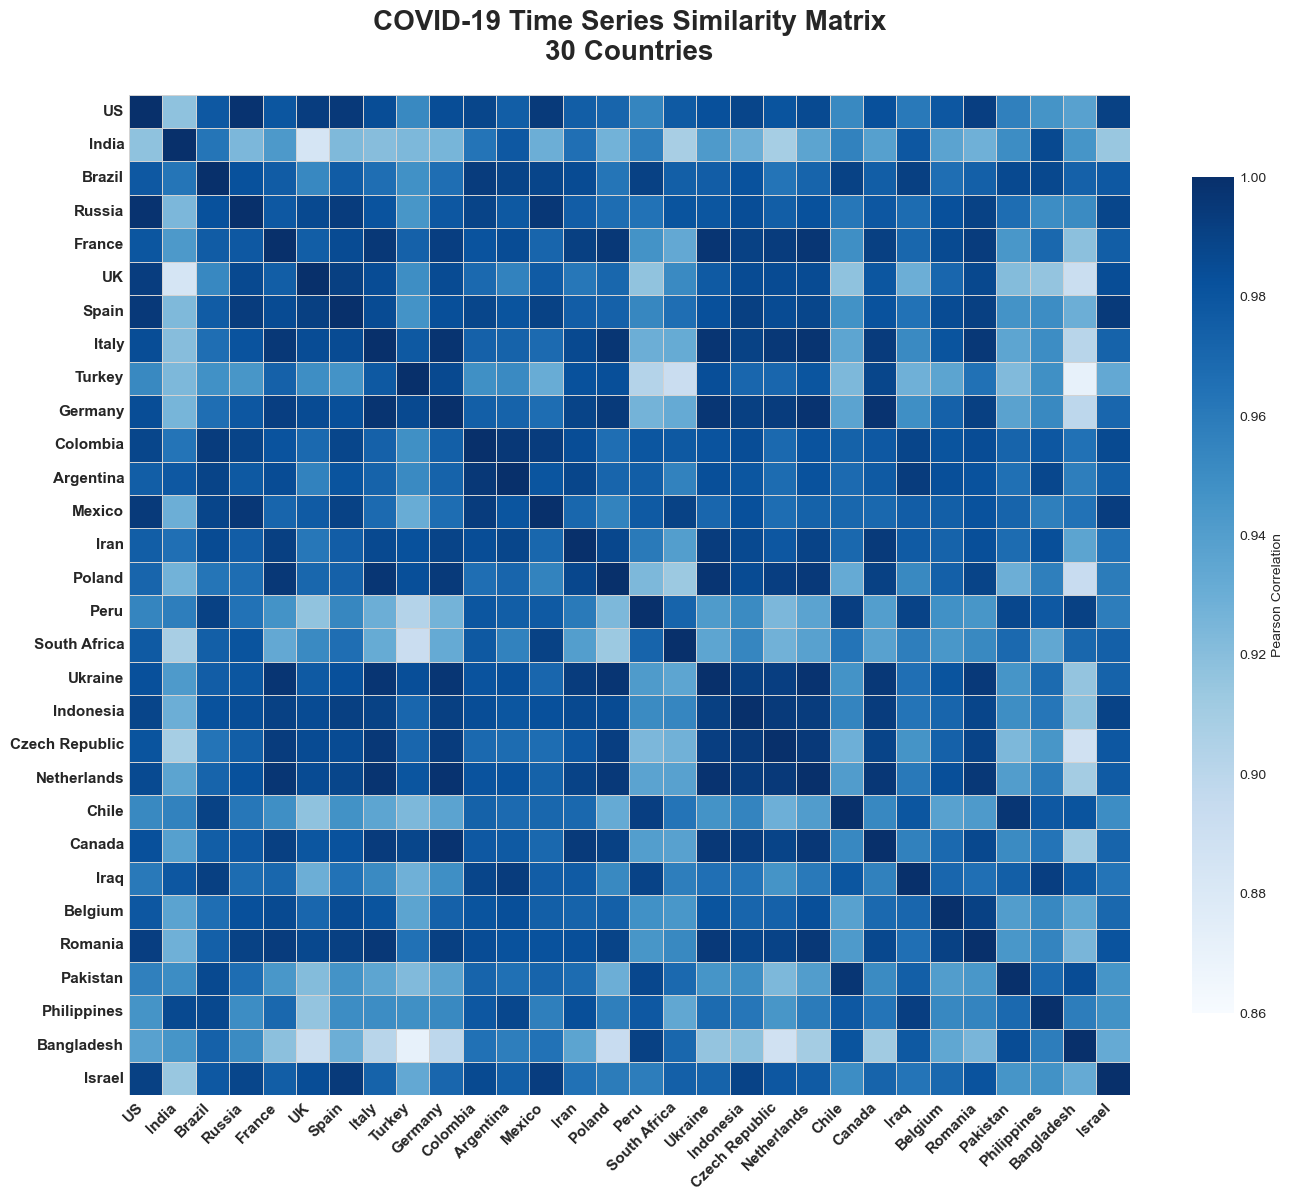

In [10]:

fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(
    similarity_matrix, 
    xticklabels=regions,          
    yticklabels=regions,          
    cmap='Blues',                 
    center=0.93,                  
    vmin=0.86,                    
    vmax=1,                       
    square=True,                  
    cbar_kws={'label': 'Pearson Correlation', 'shrink': 0.8},  
    linewidths=0.5,               
    linecolor='lightgray',        
    ax=ax
)

plt.xticks(rotation=45, ha='right', fontsize=11, fontweight='semibold')
plt.yticks(rotation=0, fontsize=11, fontweight='semibold')
plt.title(
    f'COVID-19 Time Series Similarity Matrix\n{len(regions)} Countries', 
    fontsize=20, fontweight='bold', pad=25
)
plt.tight_layout()
plt.show()


To capture a broader view of global pandemic patterns, we now expand our analysis to include the **top 50 countries** by confirmed cases.

In [12]:

df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])


ts_data = df.groupby(['Country/Region', 'ObservationDate'])['Confirmed'].sum().reset_index()
ts_pivot = ts_data.pivot(index='Country/Region', columns='ObservationDate', values='Confirmed')
ts_pivot = ts_pivot.fillna(0)


n_top = 50  

total_cases = ts_pivot.sum(axis=1).sort_values(ascending=False)
top_50 = total_cases.head(n_top).index

ts_pivot = ts_pivot.loc[top_50]
regions = ts_pivot.index.tolist()

data = ts_pivot.values
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.T).T

n_regions = len(data_scaled)
similarity_matrix = np.zeros((n_regions, n_regions))

for i in range(n_regions):
    for j in range(i, n_regions):
        if np.std(data_scaled[i]) > 0 and np.std(data_scaled[j]) > 0:
            corr = np.corrcoef(data_scaled[i], data_scaled[j])[0, 1]
            corr = 0 if np.isnan(corr) else corr
        else:
            corr = 0
        
        similarity_matrix[i, j] = corr
        similarity_matrix[j, i] = corr

print(f"Updated analysis with {n_regions} countries")

Updated analysis with 50 countries



## Graph Construction: k-Nearest Neighbors (k-NN) Graph

In [14]:
k = 6  

G = nx.Graph()
G.add_nodes_from(range(len(regions)))  

# connect each node to its k most similar neighbors
for i in range(len(regions)): 
    similarities = similarity_matrix[i].copy()
    similarities[i] = -np.inf  
    
    # Find indices of k highest similarity values
    top_k_indices = np.argsort(similarities)[-k:]
    
    for j in top_k_indices:
        G.add_edge(i, j, weight=similarity_matrix[i, j])

print(f"Graph Statistics:")
print(f"  Nodes (countries): {G.number_of_nodes()}")
print(f"  Edges (connections): {G.number_of_edges()}")
print(f"  Average degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")
print(f"  Expected avg degree with k={k}: ~{k} (edges are undirected, so may be higher)")

Graph Statistics:
  Nodes (countries): 50
  Edges (connections): 205
  Average degree: 8.20
  Expected avg degree with k=6: ~6 (edges are undirected, so may be higher)



## Community Detection: Louvain Algorithm

In [16]:

partition = community_louvain.best_partition(G, weight='weight')

# calculate modularity score for the detected communities
modularity = community_louvain.modularity(partition, G, weight='weight')

# convert partition dict to list (aligned with node order)
louvain_labels = [partition[i] for i in range(len(regions))]

print(f"Louvain Clustering Results:")
print(f"  Communities detected: {len(set(louvain_labels))}")
print(f"  Modularity score: {modularity:.4f}")

Louvain Clustering Results:
  Communities detected: 4
  Modularity score: 0.5184


In [18]:

result_df = pd.DataFrame({
    'Country': regions,
    'Community': louvain_labels
})

print("Community Assignments:")
for comm_id in sorted(set(louvain_labels)):
    members = result_df[result_df['Community'] == comm_id]['Country'].tolist()
    print(f"\nCommunity {comm_id} ({len(members)} countries):")
    print(f"  {', '.join(members)}")

result_df.sort_values(['Community', 'Country'])

Community Assignments:

Community 0 (13 countries):
  US, Russia, UK, Spain, Mexico, South Africa, Belgium, Romania, Israel, Portugal, Switzerland, Morocco, Panama

Community 1 (12 countries):
  Turkey, Germany, Iran, Indonesia, Czech Republic, Netherlands, Canada, Sweden, Japan, United Arab Emirates, Lebanon, Belarus

Community 2 (16 countries):
  India, Brazil, Colombia, Argentina, Peru, Chile, Iraq, Pakistan, Philippines, Bangladesh, Saudi Arabia, Ecuador, Kazakhstan, Nepal, Bolivia, Dominican Republic

Community 3 (9 countries):
  France, Italy, Poland, Ukraine, Hungary, Austria, Serbia, Jordan, Bulgaria


,Country,Community
24,Belgium,0
29,Israel,0
12,Mexico,0
34,Morocco,0
42,Panama,0
31,Portugal,0
25,Romania,0
3,Russia,0
16,South Africa,0
6,Spain,0



##  Visualization 2: Louvain Community Network Graph

- **Node colors**: Represent community membership (same color = same community)
- **Node positions**: Determined by spring layout (connected nodes attract each other)
- **Edges**: Show k-NN connections (faded for readability)

- Tight clusters indicate strongly connected communities
- Countries that bridge clusters may have hybrid pandemic patterns

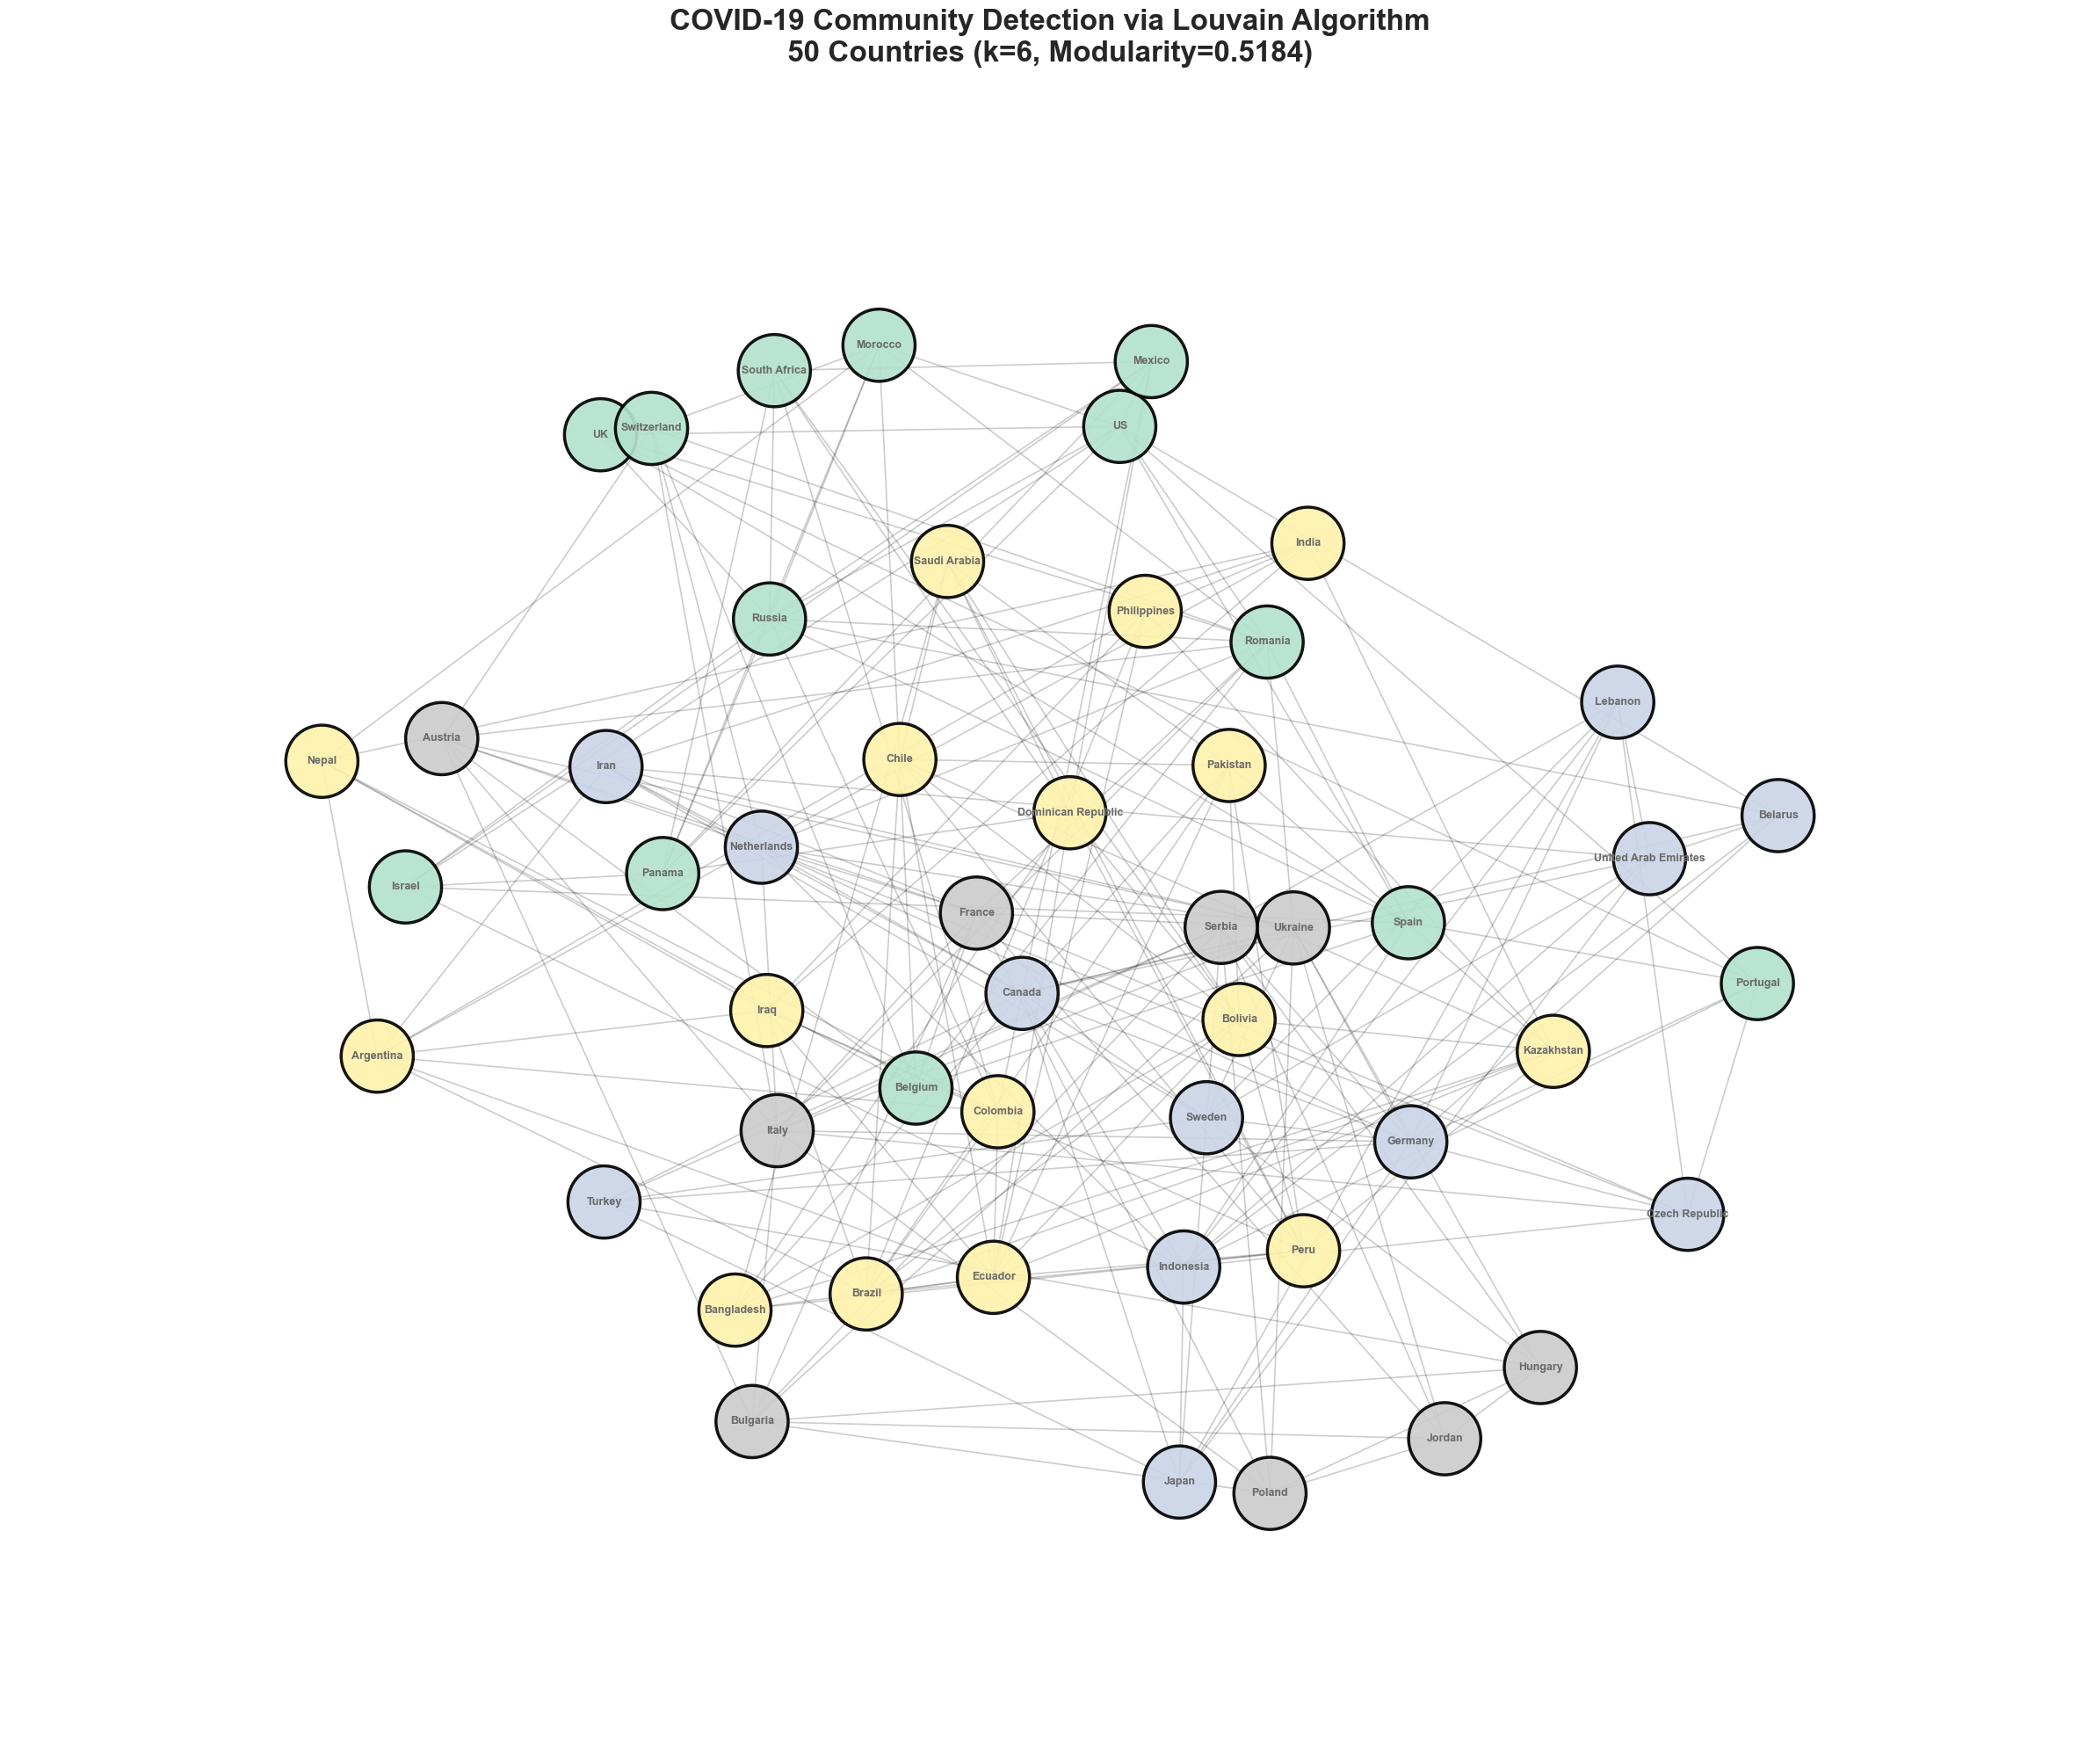

In [20]:
fig, ax = plt.subplots(figsize=(24, 20))

# calculate node positions using spring layout algorithm
# k: optimal distance between nodes, iterations: convergence steps
pos = nx.spring_layout(G, k=4, iterations=150, seed=42)


nx.draw_networkx_edges(
    G, pos, 
    width=1.2,      
    alpha=0.20,       
    ax=ax
)

nx.draw_networkx_nodes(
    G, pos, 
    node_color=louvain_labels,  
    node_size=3500,            
    cmap='Pastel2',             
    alpha=0.92,                 
    edgecolors='black',         
    linewidths=2.5,             
    ax=ax
)

nx.draw_networkx_labels(
    G, pos, 
    {i: regions[i] for i in range(n_regions)},  
    font_size=9, 
    font_weight='bold',
    font_color='dimgrey',
    ax=ax
)

ax.set_title(
    f'COVID-19 Community Detection via Louvain Algorithm\n'
    f'{len(regions)} Countries (k={k}, Modularity={modularity:.4f})', 
    fontsize=24, fontweight='bold', pad=30
)
ax.axis('off')      
ax.margins(0.15)    

plt.tight_layout()
plt.show()


## Community Detection: Spectral Clustering

In [22]:

n_clusters = min(5, n_regions - 1)

spectral = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',  
    random_state=42          
)


spectral_labels = spectral.fit_predict(similarity_matrix)

# Calculate Modularity
spectral_partition = {i: int(label) for i, label in enumerate(spectral_labels)}
spectral_modularity = community_louvain.modularity(spectral_partition, G, weight='weight')


print(f"Spectral Clustering Results:")
print(f"  Number of clusters: {n_clusters}")
print(f"  Modularity score: {spectral_modularity:.4f}")

spectral_df = pd.DataFrame({
    'Country': regions,
    'Cluster': spectral_labels
})

print("\nCluster Assignments:")
for cluster_id in sorted(set(spectral_labels)):
    members = spectral_df[spectral_df['Cluster'] == cluster_id]['Country'].tolist()
    print(f"\nCluster {cluster_id} ({len(members)} countries):")
    print(f"  {', '.join(members)}")

Spectral Clustering Results:
  Number of clusters: 5
  Modularity score: 0.3948

Cluster Assignments:

Cluster 0 (15 countries):
  US, Brazil, Russia, Mexico, Peru, South Africa, Chile, Pakistan, Bangladesh, Saudi Arabia, Ecuador, Panama, Kazakhstan, Bolivia, Dominican Republic

Cluster 1 (15 countries):
  France, Italy, Turkey, Germany, Iran, Poland, Ukraine, Netherlands, Canada, Sweden, Hungary, Serbia, Jordan, Belarus, Bulgaria

Cluster 2 (5 countries):
  India, Argentina, Iraq, Philippines, Nepal

Cluster 3 (5 countries):
  Belgium, Romania, Switzerland, Morocco, Austria

Cluster 4 (10 countries):
  UK, Spain, Colombia, Indonesia, Czech Republic, Israel, Portugal, Japan, United Arab Emirates, Lebanon



## Visualization 3: Spectral Clustering Network Graph

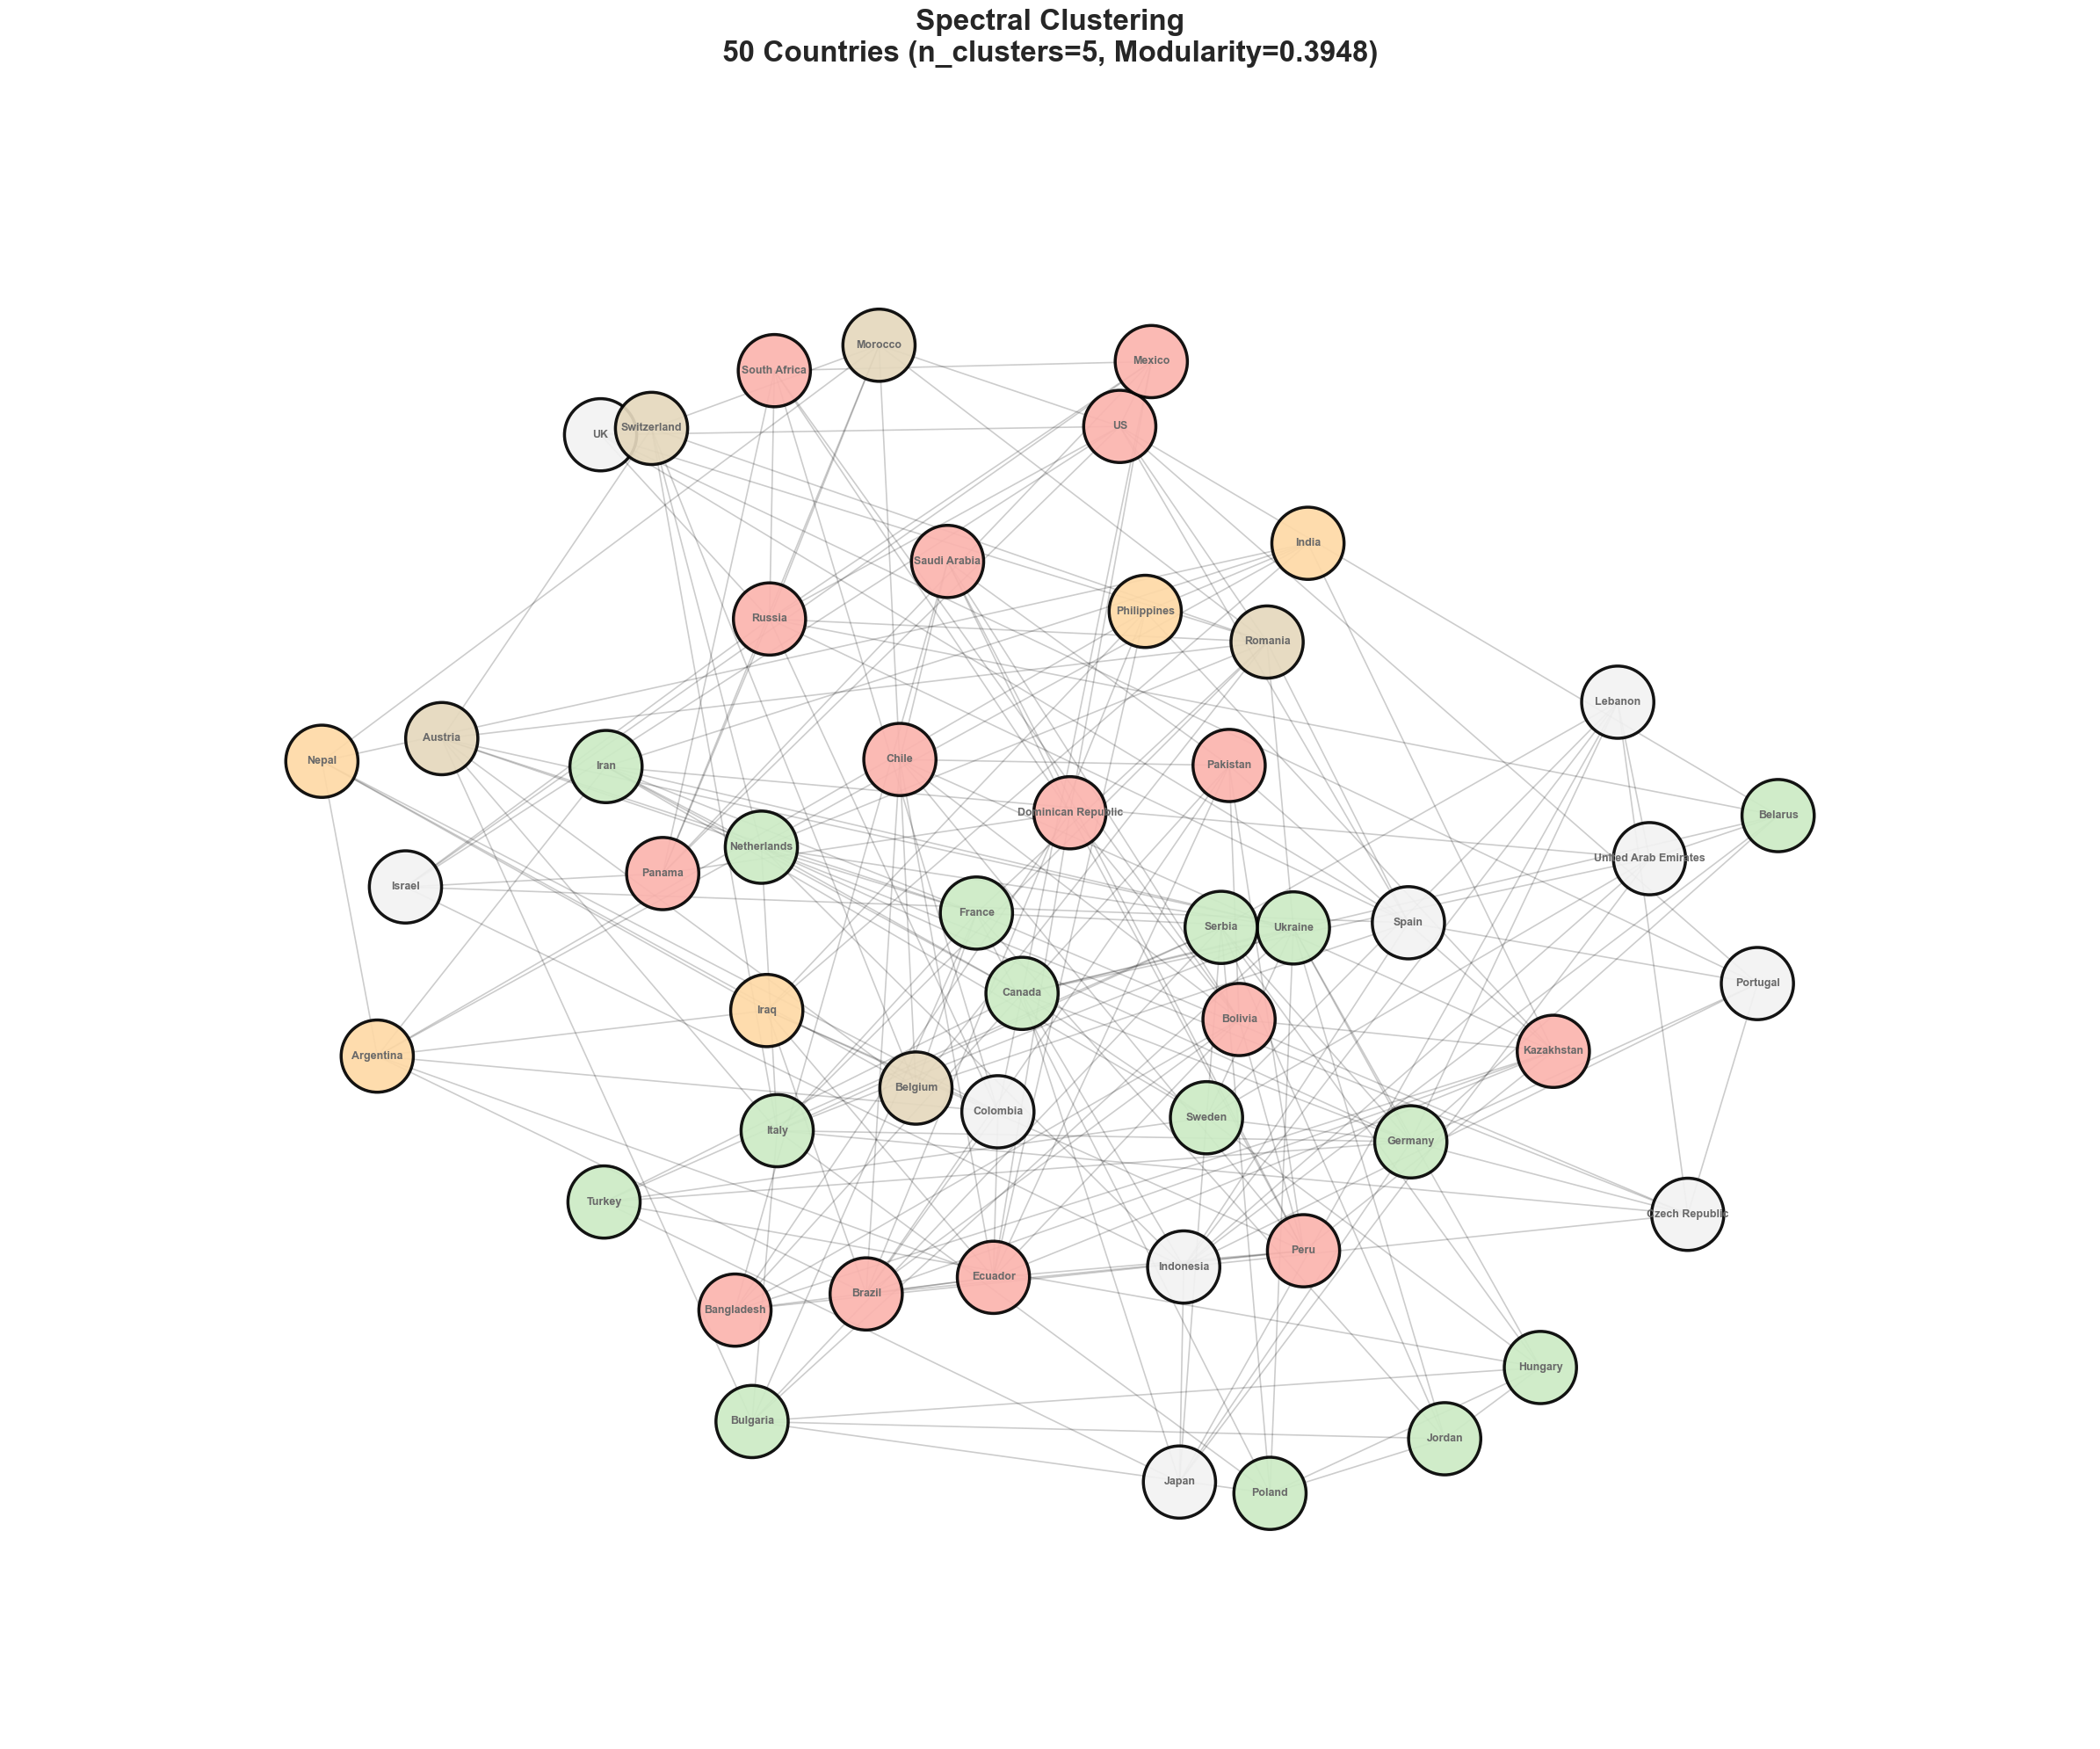

In [24]:

fig, ax = plt.subplots(figsize=(24, 20))


nx.draw_networkx_edges(
    G, pos,          
    width=1.2, 
    alpha=0.2, 
    ax=ax
)


nx.draw_networkx_nodes(
    G, pos, 
    node_color=spectral_labels,  
    node_size=3500,
    cmap='Pastel1',             
    alpha=0.92,
    edgecolors='black',
    linewidths=2.5,
    ax=ax
)


nx.draw_networkx_labels(
    G, pos, 
    {i: regions[i] for i in range(n_regions)}, 
    font_size=9, 
    font_weight='bold',
    font_color='dimgrey',
    ax=ax
)


ax.set_title(
    f'Spectral Clustering\n'
    f'{len(regions)} Countries (n_clusters={n_clusters}, Modularity={spectral_modularity:.4f})', 
    fontsize=24, fontweight='bold', pad=30
)
ax.axis('off')
ax.margins(0.15)

plt.tight_layout()
plt.show()


## Notes


### Key Findings:

1. **High Correlation**: Most countries show high correlation (>0.86), suggesting similar global pandemic waves

2. **Community Structure**: Modularity scores indicate meaningful community structure exists in the data

3. **Interpretation**: Countries in the same cluster likely experienced:
   - Similar timing of outbreak peaks
   - Comparable growth/decay patterns
   - Potentially similar policy responses or regional connections

### Limitations:

- Correlation measures **shape**, not **magnitude** of outbreaks
- Results depend on hyperparameter choices (k, n_clusters)
- Time series length and data quality affect results
- Does not account for population size or testing capacity differences